In [11]:
# Import and read a dataset from an external file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

craters = pd.read_csv("AstroStats_Robbins_Moon.csv", sep = ",")

#indexing from a certain row
print (craters[60:])

       Unnamed: 0    CRATER_ID  LAT_CIRC_IMG  LON_CIRC_IMG  LAT_ELLI_IMG  \
60             60  01-1-000026       61.6941      172.3650       61.6953   
61             61  01-1-000027       62.8265      177.1930       62.8215   
62             62  01-1-000028       62.5616      175.1740       62.5700   
63             63  01-1-000029       62.4650      177.6320       62.4484   
64             64  01-1-000030       63.3087      179.7250       63.3068   
...           ...          ...           ...           ...           ...   
83056     1296791  10-2-014997      -65.6258      203.5000      -65.6216   
83057     1296792  10-3-000000      -60.0296      178.7090      -60.0301   
83058     1296793  10-3-000003      -66.7921      219.3790      -66.7951   
83059     1296794  10-3-000004      -79.8374       62.1794      -79.8408   
83060     1296795  10-3-000005      -79.6855       61.9220      -79.7055   

       LON_ELLI_IMG  DIAM_CIRC_IMG  DIAM_CIRC_SD_IMG  DIAM_ELLI_MAJOR_IMG  \
60        

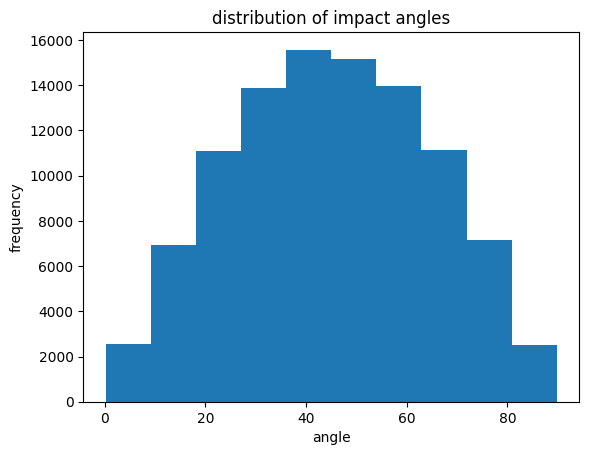

In [15]:
# generate random impact scenarios for MOnte Carlo modeling
import random # importing the Python random library

angles=[] #declare list
for _ in range(100000): # asking this to do stuff 10000 times
    u=random.uniform(0,1) # random number between 0 and 1
    angle=(90/np.pi)*np.arccos(2*u-1) # Distribution of angles according to Mathias et al.
    angles.append(angle)

plt.hist(angles)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('distribution of impact angles')
plt.show()

In [38]:
# Make a gaussian distribution of densities with the correct fraction
asteroid_types=["H","L","LL","CM","IAB","IIIAB","EUC","DIO","HOW"]
asteroid_densities=[3.38,3.3,3.19,2.27,6.75,7.15,2.84,3.12,2.86]
std_densities=[0.19,0.12,0.14,0.13,1.84,0.57,0.13,0.19,0.11]
fraction_of_total=[.349,.389,.093,.043,.025,.024,.034,.011,.034]

# TODO: figure out how to make this distribution correct
densities=[]
#for i in range(len(asteroid_densities)):
    #number_of_times=1000000*fraction_of_total[i]
for _ in range(10000):
       # density=np.random.normal(np.mean(asteroid_densities[i]), np.std(std_densities[i]), size=None)
       # densities.append(density)
    density=min(asteroid_densities)*random.weibullvariate(1, 1.5)+10
    densities.append(density)





Text(0.5, 1.0, 'Density distribution')

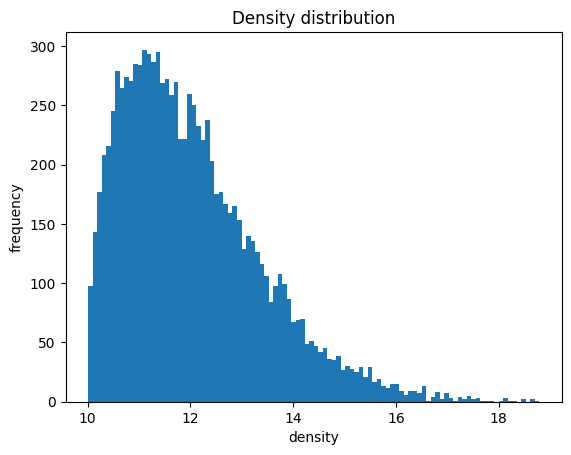

In [39]:
plt.hist(densities, bins=100)
plt.xlabel('density')
plt.ylabel('frequency')
plt.title('Density distribution')

In [ ]:
# Find all craters likely caused by asteroids >140m
big_craters=[]
for crater in craters: